# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project, I will create a few different machine learning models to predict the total number of bikes people rented in a given hour and evaluate their performance. The data set used in this project is from [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home). The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

## Summary of results

Three models have been created and MSE is used to evaluate their performances. We can see that Random forest model performs the best so far. But the difference between the MSE of training set and testing set is large. I consider the model is overfitted. It also appears in the Decision tree model.

## Further Study

Here are some potential next steps:

Calculate additional features, such as:
- An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.

## Reading in Dataset

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
bike_rentals = pd.read_csv('bike_rental_hour.csv')

## Primary exploration of the Dataset

In [434]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike - - sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

I'll predict the cnt column using all of the other columns, except for casual and registered.

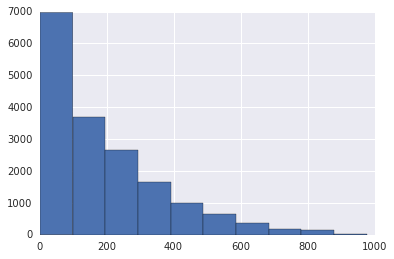

In [435]:
# distribution of total rentals
plt.hist(bike_rentals['cnt'])
plt.show()

In [436]:
# explore how each column is correlated with cnt
corr_with_cnt = abs(bike_rentals.corr()['cnt']).sort_values(ascending = False)
corr_with_cnt

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

As 'cnt' value is the sum of 'casual' and 'registered', it is not surprising that 'casual' and 'registered'have the highest correlation with 'cnt'. Besides these columns, we can see that Temperature of the day ('temp' and 'atemp'), the hour the rentals occurred ('hr') and the humidity ('hum') are the top 3 features which have a high correlation with the total number of bike rentals ('cnt') of that day.

## Feature Engineering

### Creating labels for hr column
I will create a new column with labels for morning, afternoon, evening, and night for the 'hr' column.

In [437]:
# function for assigning labels
def assign_label(hour):
    if hour in range(6,12):
        label = 1
    elif hour in range(12,18):
        label = 2
    elif hour in range(18,24):
        label = 3
    else:
        label = 4
    return label

# apply assign_label function to hr column
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Features selection

Only the features that have a correlation of 0.3 or higher

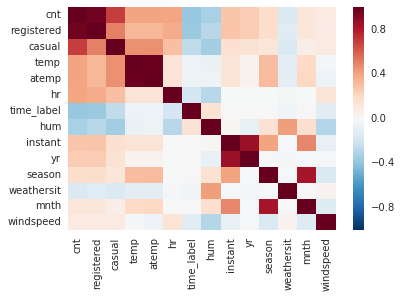

In [438]:
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = bike_rentals[strong_corrs.index].corr()
sns.heatmap(corrmat)

For the features of the model,
- 'casual'and 'registered' will be excluded for the list of features because those numbers are added together to get cnt
- 'dteday' will be excluded because it represents the date of the rental only
- There is a strong corrlation between 'temp' and 'atemp', which is reasonable. 'temp' will be excluded to avoid double counting
- 'instant' will be excluded because it's only a sequential ID number for each row

In [439]:
features = list(bike_rentals.columns)
features.remove('cnt')
features.remove('casual')
features.remove('registered')
features.remove('dteday')
features.remove('temp')
features.remove('instant')
features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

## Error Matric

The mean squared error metric will be used to evaluate the performance of the machine learning algorithms, as MSE works on continuous numeric data, which fits our data quite well.

## Spliting the data

80% of the rows in the data set will be assigned to be part of the training set using the sample method. The other 20% will be assigned to the test set.

In [440]:
# assign rows to train set and test set
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

Linear regression works best when predictors are linearly correlated to the target and also independent. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [441]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])
mse = mean_squared_error(predictions, test['cnt'])
rmse = np.sqrt(mse)
print(mse)
print(rmse)

17058.144018902374
130.60682990909157


The mean squared error of the Linear Regression model is 17052 and the rmse is 130. It seems like the model is not so accurate.

## Decision tree algorithm

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [442]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=1)
dt.fit(train[features], train['cnt'])
train_predictions = dt.predict(train[features])
test_predictions = dt.predict(test[features])
train_mse = mean_squared_error(train_predictions, train['cnt'])
test_mse = mean_squared_error(test_predictions, test['cnt'])
print('train set: ', train_mse)
print('test set: ', test_mse)

train set:  0.32417463856721573
test set:  3639.307825086306


The mean squared error of the Decision tree model is 0.32 for the train set and 3639 for the test set. The model is totally overfitted, let try to improve it.

### Changing min_samples_leaf

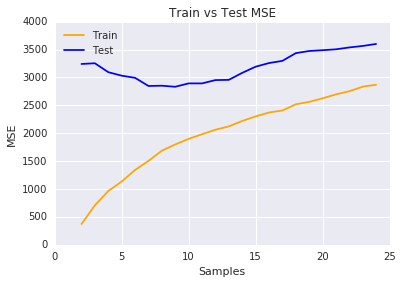

In [443]:
train_mse = []
test_mse = []
samples = range(2,25)
for i in samples:
    dt = DecisionTreeRegressor(random_state=1, min_samples_leaf=i)
    dt.fit(train[features], train['cnt'])
    train_predictions = dt.predict(train[features])
    test_predictions = dt.predict(test[features])
    train_mse.append(mean_squared_error(train_predictions, train['cnt']))
    test_mse.append(mean_squared_error(test_predictions, test['cnt']))
    
plt.plot(samples, train_mse, color="orange")
plt.plot(samples, test_mse, color="blue")
plt.title("Train vs Test MSE")
plt.xlabel("Samples")
plt.ylabel("MSE")
plt.legend(["Train", "Test"], loc=0)

### Changing max_depth

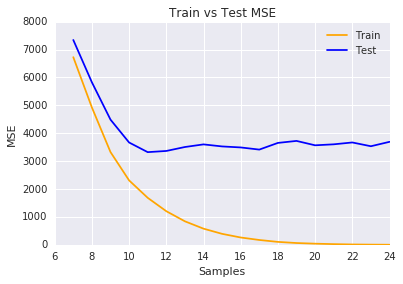

In [444]:
train_mse = []
test_mse = []
samples = range(7,25)
for i in samples:
    dt = DecisionTreeRegressor(random_state=1, max_depth=i)
    dt.fit(train[features], train['cnt'])
    train_predictions = dt.predict(train[features])
    test_predictions = dt.predict(test[features])
    train_mse.append(mean_squared_error(train_predictions, train['cnt']))
    test_mse.append(mean_squared_error(test_predictions, test['cnt']))
    
plt.plot(samples, train_mse, color="orange")
plt.plot(samples, test_mse, color="blue")
plt.title("Train vs Test MSE")
plt.xlabel("Samples")
plt.ylabel("MSE")
plt.legend(["Train", "Test"], loc=0)

## Random forest algorithm

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [445]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1)
rf.fit(train[features], train['cnt'])
train_predictions = rf.predict(train[features])
test_predictions = rf.predict(test[features])
train_mse = mean_squared_error(train_predictions, train['cnt'])
test_mse = mean_squared_error(test_predictions, test['cnt'])
print('train set: ', train_mse)
print('test set: ', test_mse)

train set:  350.80718163785593
test set:  2180.906968817926


### Changing min_samples_leaf

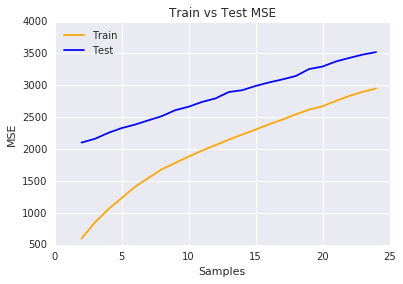

In [446]:
train_mse = []
test_mse = []
samples = range(2,25)

for i in samples:
    rf = RandomForestRegressor(random_state=1, min_samples_leaf=i)
    rf.fit(train[features], train['cnt'])
    train_predictions = rf.predict(train[features])
    test_predictions = rf.predict(test[features])
    train_mse.append(mean_squared_error(train_predictions, train['cnt']))
    test_mse.append(mean_squared_error(test_predictions, test['cnt']))
    
plt.plot(samples, train_mse, color="orange")
plt.plot(samples, test_mse, color="blue")
plt.title("Train vs Test MSE")
plt.xlabel("Samples")
plt.ylabel("MSE")
plt.legend(["Train", "Test"], loc=0)

### Changing max_depth

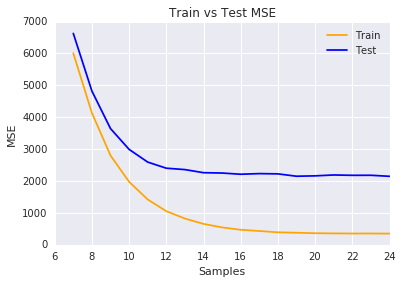

In [447]:
train_mse = []
test_mse = []
samples = range(7,25)

for i in samples:
    rf = RandomForestRegressor(random_state=1, max_depth=i)
    rf.fit(train[features], train['cnt'])
    train_predictions = rf.predict(train[features])
    test_predictions = rf.predict(test[features])
    train_mse.append(mean_squared_error(train_predictions, train['cnt']))
    test_mse.append(mean_squared_error(test_predictions, test['cnt']))
    
plt.plot(samples, train_mse, color="orange")
plt.plot(samples, test_mse, color="blue")
plt.title("Train vs Test MSE")
plt.xlabel("Samples")
plt.ylabel("MSE")
plt.legend(["Train", "Test"], loc=0)

## Interim Conclusion

In this project, I have created three models and use MSE to evaluate their performances. We can see that Random forest model performs the best so far. But the difference between the MSE of training set and testing set is large. I consider the model is overfitted. It also appears in the Decision tree model.

## Further Study

Here are some potential next steps:

Calculate additional features, such as:
- An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.